In [1]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import math
import sh

IOSTAT_COLUMNS = ['r/s', 'w/s', 'kr/s', 'kw/s', 'wait', 'actv', 'wsvc_t', 'asvc_t', '%w', '%b', 'device']
TEST_CONFIG = 'fixed-rate-submit'
DISK_CONFIG = 'hdd'

NJOBS = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
NDISKS = [1, 2, 4, 8]

DISKS = ['c1t1d0', 'c1t2d0', 'c1t3d0', 'c2t0d0', 'c2t1d0', 'c2t2d0',
         'c4t0d0', 'c4t1d0', 'c4t2d0', 'c3t0d0', 'c3t1d0']

seaborn.set(font_scale=1.5)

jq = sh.jq.bake('-M', '-r')

def fio_iops_series(directory):
    iops = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.iops', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        iops.append(float(data.strip()))
    return pd.Series(iops, NJOBS)

def fio_latency_series(directory):
    latency = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.lat.mean', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        latency.append(float(data.strip()))
    return pd.Series(latency, NJOBS)

def iostat_column_series(column, directory, ndisks):
    jobavgs = []
    for njobs in NJOBS:
        diskavgs = pd.Series()
        for disk in DISKS[0:ndisks]:
            data = pd.read_csv('{:s}/fio-{:d}-jobs/iostat-{:s}.txt'.format(directory, njobs, disk),
                               delim_whitespace=True, header=None, names=IOSTAT_COLUMNS, skiprows=5)
            diskavgs[disk] = data[column].mean()
        jobavgs.append(data[column].mean())
    return pd.Series(jobavgs, NJOBS)

def get_pctchange_dataframe(project, master):
    diff = pd.DataFrame()
    for plabel, mlabel in zip(project, master):
        new = project[plabel]
        old = master[mlabel]
        diff[plabel] = 100 * ((new - old) / old)
    return diff

def plot_iops_dataframe(df):
    df.plot(figsize=(30, 15), style=':o')
    plt.title('fio -- write iops vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('write iops reported by fio')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_latency_dataframe(df):
    df.plot(figsize=(30, 15), style=':o')
    plt.title('fio -- average write latency vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('average write latency reported by fio (microseconds)')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_iostat_column_dataframe(df, column):
    df.plot(figsize=(30, 15), style=':o')
    plt.title('iostat -- {:s} vs. fio threads'.format(column))
    plt.xlabel('number of fio threads issuing writes')
    plt.xscale('log')
    plt.xticks(df.index, df.index)
    plt.show()

In [2]:
master_latency = pd.DataFrame()
master_iops = pd.DataFrame()
master_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'results/{:s}/master/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'master - {:d} {:s}'.format(i, DISK_CONFIG)
    master_latency[label] = fio_latency_series(directory)
    master_iops[label] = fio_iops_series(directory)
    master_busy[label] = iostat_column_series('%b', directory, i)

project_latency = pd.DataFrame()
project_iops = pd.DataFrame()
project_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'results/{:s}/project/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'project - {:d} {:s}'.format(i, DISK_CONFIG)
    project_latency[label] = fio_latency_series(directory)
    project_iops[label] = fio_iops_series(directory)
    project_busy[label] = iostat_column_series('%b', directory, i)

pctchange_latency = get_pctchange_dataframe(project_latency, master_latency)
pctchange_iops = get_pctchange_dataframe(project_iops, master_iops)

# OpenZFS #447 Performance Results - Fixed Rate Submit on HDDs

### Workload Details

This workload consisted of using `fio` to drive synchronous writes, while varying the number of threads used by `fio`. Each `fio` thread would issue writes to a unique file, using sequential file offsets, `pwrite`, `O_SYNC`, a blocksize of `8k`, and a queue depth of 1 (i.e. each thread performing a single write at a time). Additionally, each thread would attempt to acheive a bandwidth of about 64 writes per second; i.e. after a write completes, the thread may artficially delay, such that it doesn't exceed its target of 64 write operations per second. Here's the `fio` configuration used to acheive this:
```
[global]
group_reporting
clocksource=cpu
ioengine=psync
fallocate=none
blocksize=8k
runtime=60
time_based
iodepth=1
rw=write
thread=0
direct=0
sync=1

# Real world random request flow follows Poisson process. To give better
# insight on latency distribution, we simulate request flow under Poisson
# process.
rate_process=poisson
rate_iops=64

[zfs-workload]
```

The command line flag `--numjobs` was used to vary the number of threads used for each invocation, ranging from a single thread to 1024 threads.

### ZFS Pool and Dataset Configuration

The above `fio` workload was run on zpools with varying numbers of direct attached disks; configurations of 1 disk, 2 disks, 4 disks, and 8 disks were used. All configuration options were kept default at the zpool level (i.e. no `-o` options were passed to `zpool create`).

For all tests, a single ZFS dataset was used to store all the `fio` files for all thread counts. The configuration options used for this dataset were the following: `recsize=8k`, `compress=lz4`, `checksum=edonr`, `redundant_metadata=most`. These were all chosen to match the options used by our Delphix Engine, except `recsize`, which was used to avoid the read-modify-write penalty since `fio` was issuing `8k` writes.

### System Hardware Configuration

 - VM running on VMWare ESXi 6.0.0
 - 8 vCPUs
 - 128 GB of RAM
 - Traditional Magnetic Disks

## IOPs as reported by `fio` vs. number of `fio` threads

Below is a graph of the write IOPs reported by `fio` (using the `write.iops` metric), which accounts for all `fio` threads in the given run; i.e. it's the aggregate value for all `fio` threads vs. the value of each individual `fio` thread. Additionally, each line corresponds to a different zpool configuration; each configuration having a different number of disks in the pool.

### IOPs as reported by `fio` vs. number of `fio` threads - master branch

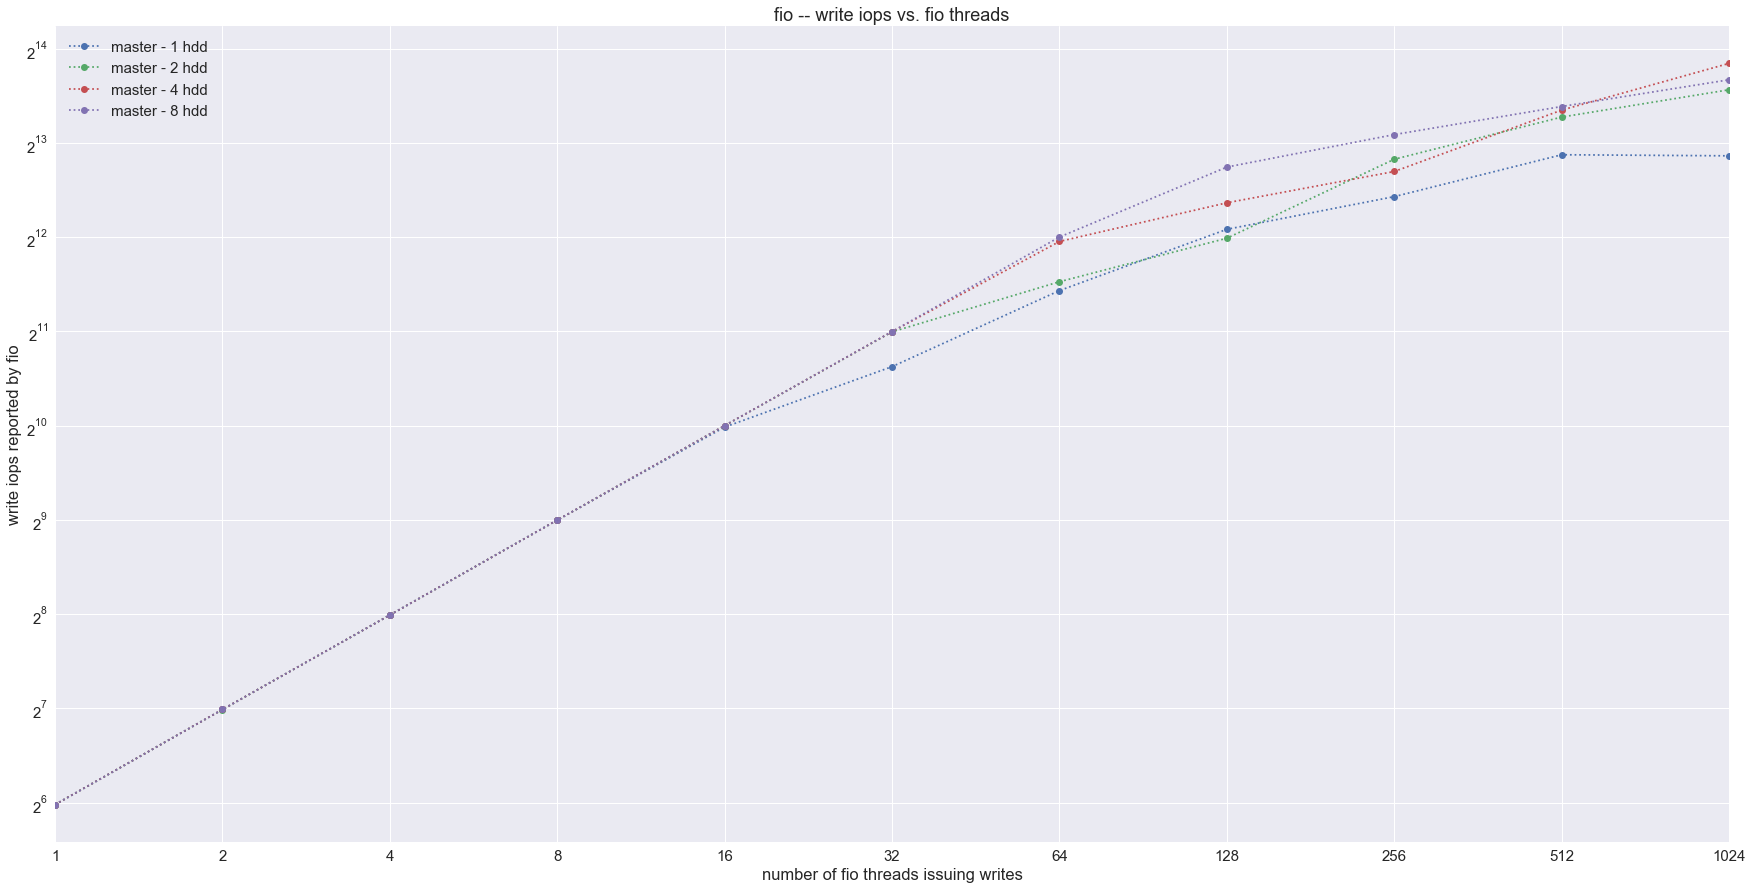

In [3]:
plot_iops_dataframe(master_iops)

In [4]:
master_iops

,master - 1 hdd,master - 2 hdd,master - 4 hdd,master - 8 hdd
1,63.086019,63.102834,63.104936,63.082127
2,127.009245,126.975404,127.017708,126.991003
4,254.418550,254.261553,254.274251,254.261553
8,511.529490,511.119989,511.153654,511.153283
16,1012.911932,1023.721139,1023.906240,1023.873739
32,1579.966344,2040.357250,2043.733768,2044.513992
64,2763.592435,2949.631777,3966.092375,4096.571134
128,4336.204455,4061.521290,5269.706157,6852.563355
256,5514.430363,7257.887723,6633.361079,8700.940961
512,7502.346636,9897.906500,10417.680846,10696.507894


### IOPs as reported by `fio` vs. number of `fio` threads - project branch

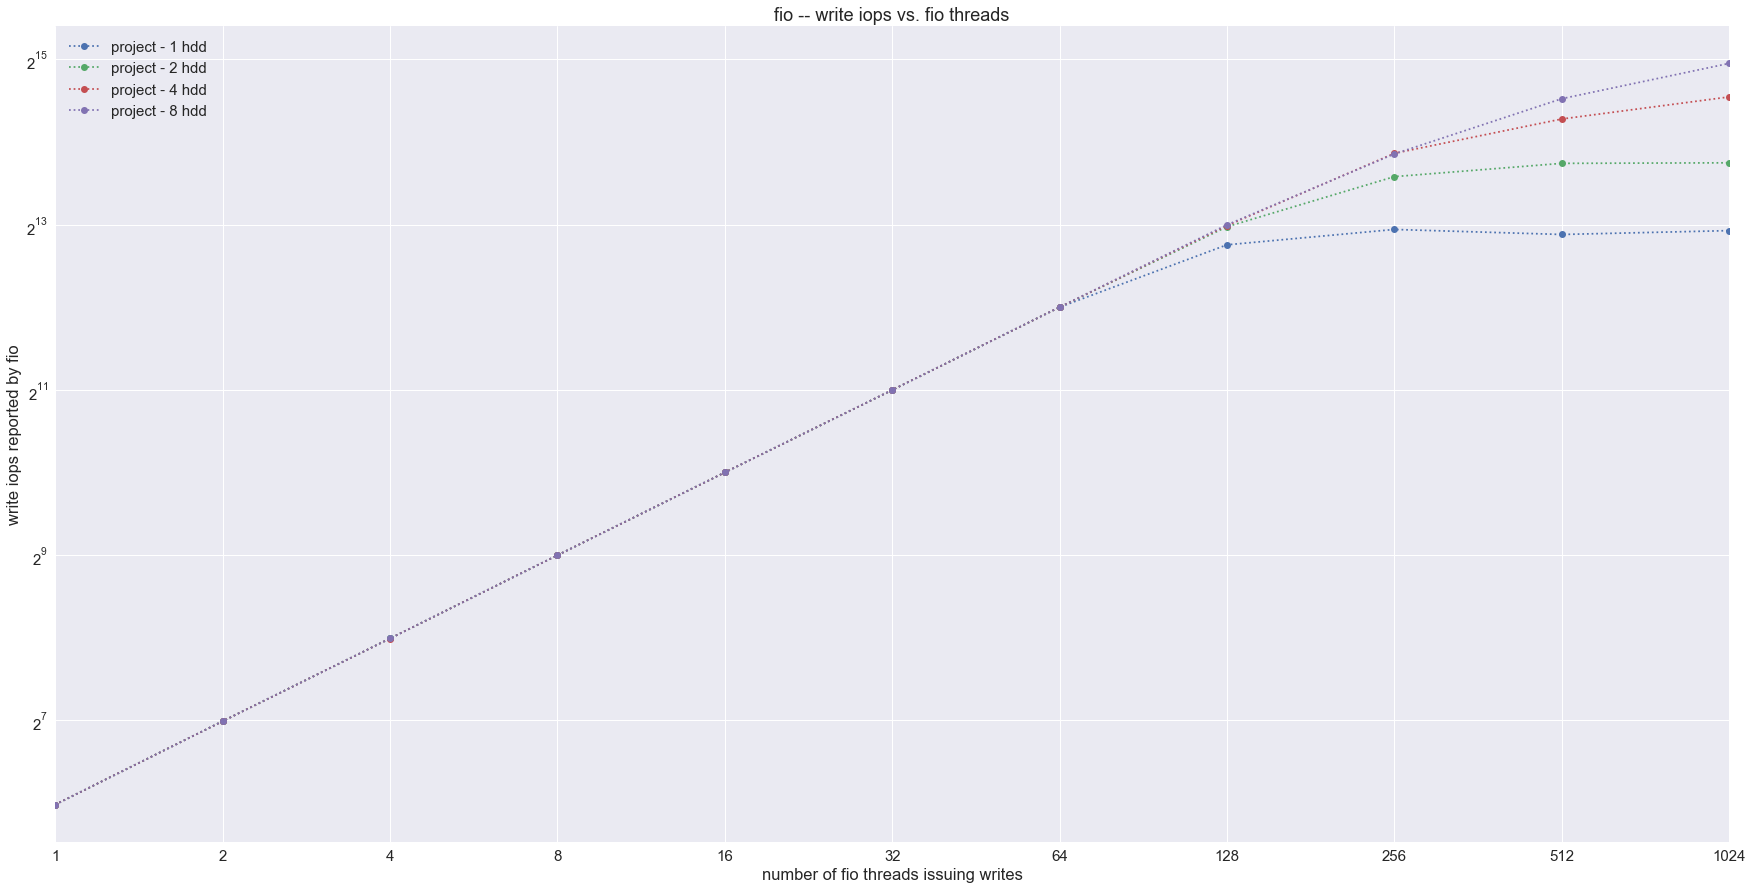

In [5]:
plot_iops_dataframe(project_iops)

In [6]:
project_iops

,project - 1 hdd,project - 2 hdd,project - 4 hdd,project - 8 hdd
1,63.101782,63.071313,63.095476,63.068617
2,127.026172,127.019823,126.943695,126.973816
4,254.265785,254.261553,254.210772,254.253088
8,511.137378,511.161792,511.161420,511.203969
16,1023.837267,1023.939137,1023.870957,1024.023974
32,2044.046410,2044.365646,2045.149471,2044.983102
64,4096.971413,4097.333933,4097.285595,4099.205622
128,6915.025820,8045.968777,8124.390041,8179.748522
256,7865.908106,12252.785203,14895.994003,14823.153267
512,7541.328245,13695.750557,19872.590386,23560.001332


## % change in write IOPs vs. number of `fio` threads - master vs. project

The following graph shows the percentage change for the IOPs reported by `fio`, between the "master" and "project" test runs. A positive value here reflects an increase in the IOPs reported by fio when comparing the results of the "project" branch to the "master" branch; i.e. positive is better. Additionally, a 100% increase would reflect a doubling of the IOPs. Similarly, a 50% decrease would equate to halving the IOPs.

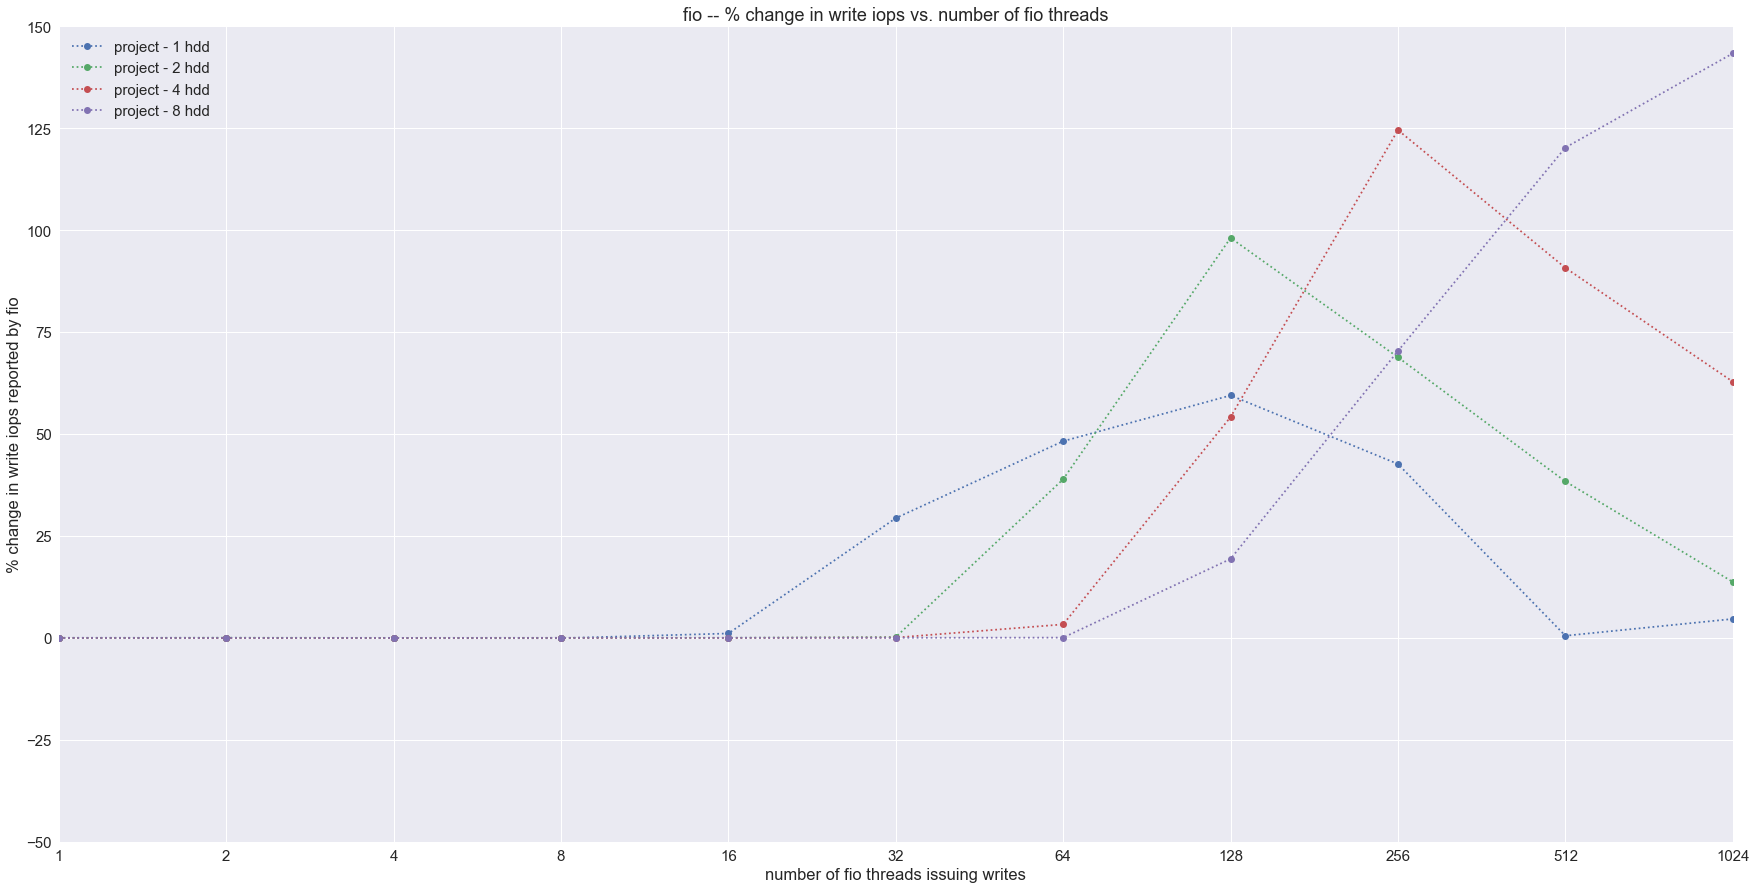

In [7]:
pctchange_iops.plot(figsize=(30, 15), style=':o')
plt.title('fio -- % change in write iops vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in write iops reported by fio')
plt.ylim(-50, 150)
plt.xscale('log')
plt.xticks(pctchange_iops.index, pctchange_iops.index)
plt.show()

In [8]:
pctchange_iops

,project - 1 hdd,project - 2 hdd,project - 4 hdd,project - 8 hdd
1,0.024987,-0.049952,-0.014991,-0.021417
2,0.013327,0.034982,-0.058270,-0.013534
4,-0.060045,0.000000,-0.024965,-0.003329
8,-0.076655,0.008179,0.001519,0.009916
16,1.078607,0.021295,-0.003446,0.014673
32,29.372782,0.196456,0.069270,0.022945
64,48.248033,38.910015,3.307871,0.064310
128,59.471858,98.102342,54.171595,19.367718
256,42.642260,68.820264,124.561784,70.362646
512,0.519592,38.370175,90.758295,120.258813


## average write latency as reported by `fio` vs. number of `fio` threads

Below are graphs of the average write latency (in microseconds) reported by `fio` (using the `write.lat.mean` metric), for all `fio` threads in the test run. Just like the graph of IOPs above, each line represents a different zpool configuration, and there's data for the "master" branch as well as the "project" branch.

## average write latency as reported by `fio` vs. number of `fio` threads - maser branch

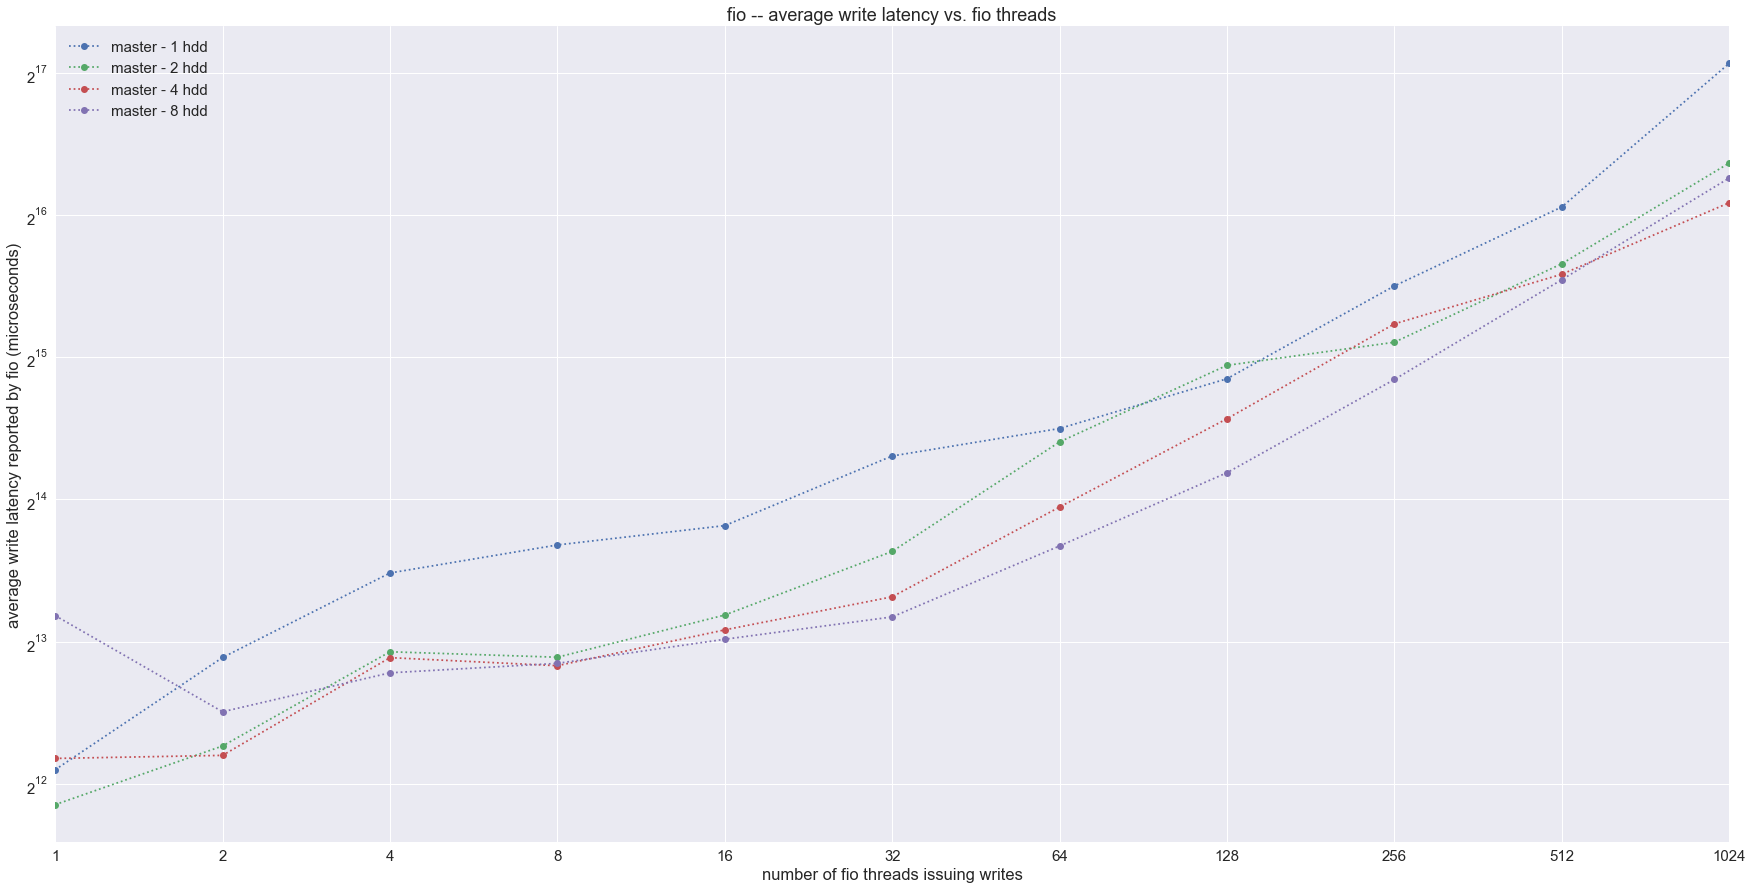

In [9]:
plot_latency_dataframe(master_latency)

In [10]:
master_latency

,master - 1 hdd,master - 2 hdd,master - 4 hdd,master - 8 hdd
1,4386.720697,3699.620116,4634.929778,9300.949023
2,7581.838951,4925.282754,4704.590820,5819.004461
4,11447.210895,7796.208655,7576.114443,7035.875409
8,13123.875513,7591.445740,7284.120111,7367.676871
16,14422.498594,9326.144167,8674.434834,8286.968943
32,20250.782469,12715.911801,10192.632968,9240.433543
64,23154.195952,21693.105609,15790.146192,13058.831704
128,29511.755590,31506.163454,24283.091051,18665.823596
256,46402.835204,35261.516869,38564.844366,29406.862271
512,68193.031212,51705.126769,49121.286463,47834.087059


### average write latency as reported by `fio` vs. number of `fio` threads - project branch

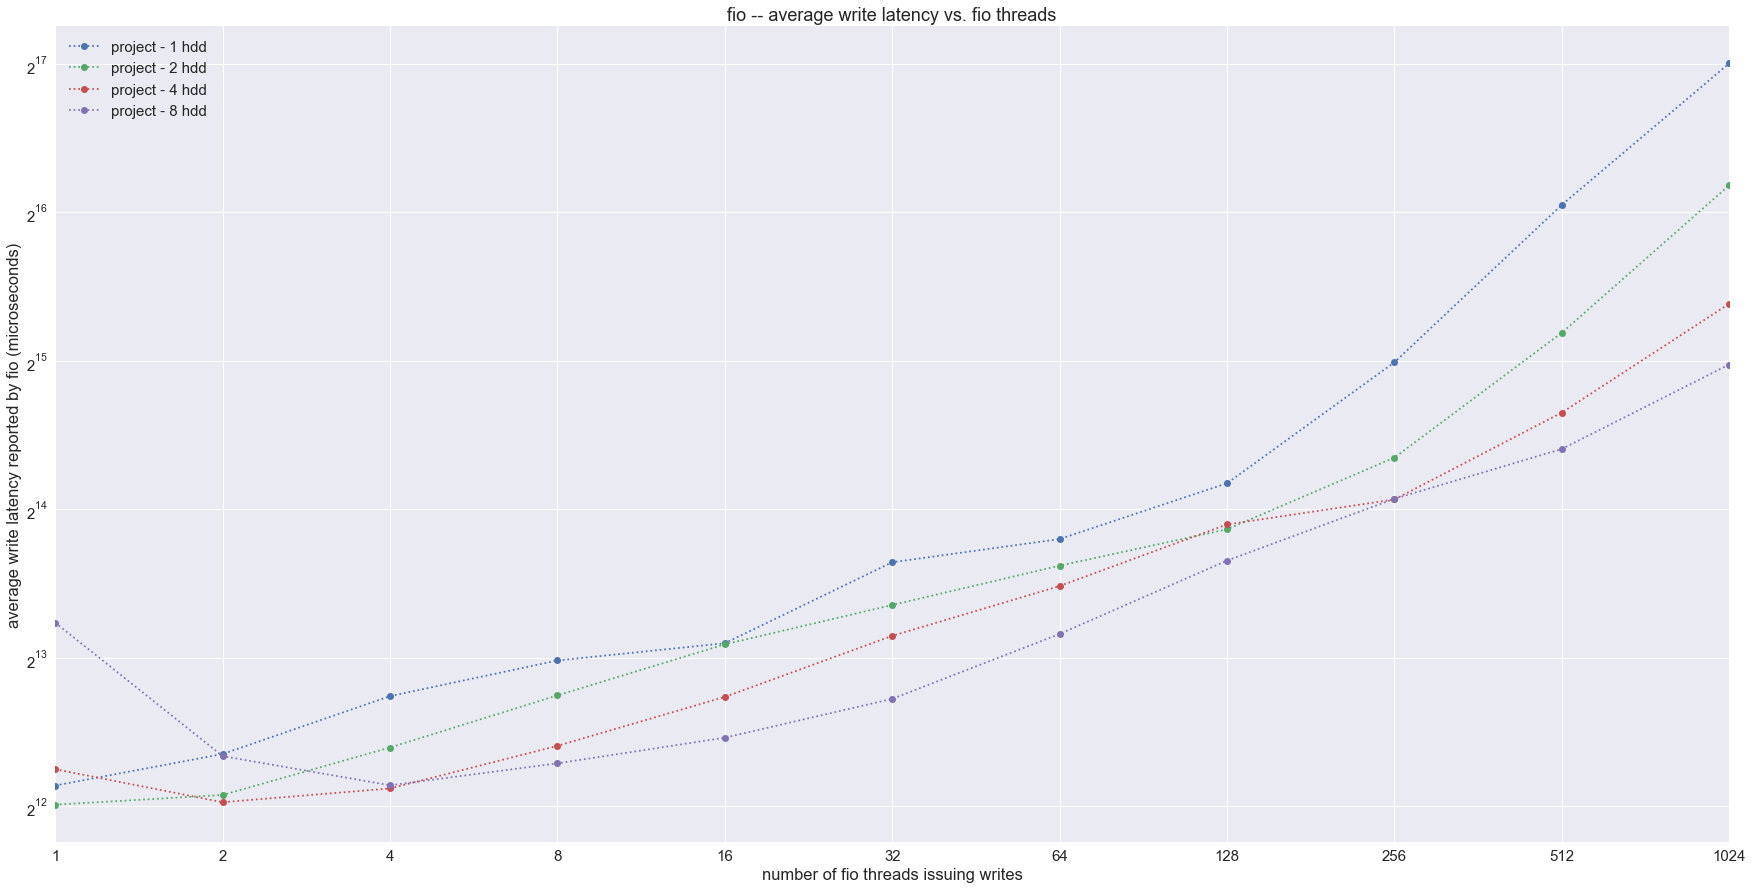

In [11]:
plot_latency_dataframe(project_latency)

In [12]:
project_latency

,project - 1 hdd,project - 2 hdd,project - 4 hdd,project - 8 hdd
1,4513.293031,4127.678986,4870.434266,9654.541612
2,5227.947541,4318.056393,4174.912262,5178.429621
4,6849.039282,5389.744533,4451.872463,4518.127472
8,8090.717031,6873.544714,5430.948839,5005.293451
16,8768.124963,8723.167266,6825.245127,5642.219142
32,12796.924515,10481.289350,9074.934536,6763.687209
64,14259.329574,12593.701803,11451.749913,9156.383185
128,18499.822620,14924.895262,15264.485818,12896.194477
256,32536.370185,20853.088543,17152.628998,17208.747745
512,67855.529156,37349.433450,25731.465659,21711.894166


## % change in average write latency vs. number of `fio` threads -  master vs. project

The following graph shows the percentage change for the average write latency reported by `fio`, between the "master" branch and "project" branch test runs. A positive value here reflects an increase in the average write latency reported by `fio` when comparing the "project" to the "baseline". Thus, unlike the IOPs numbers above, a negative value here is better.

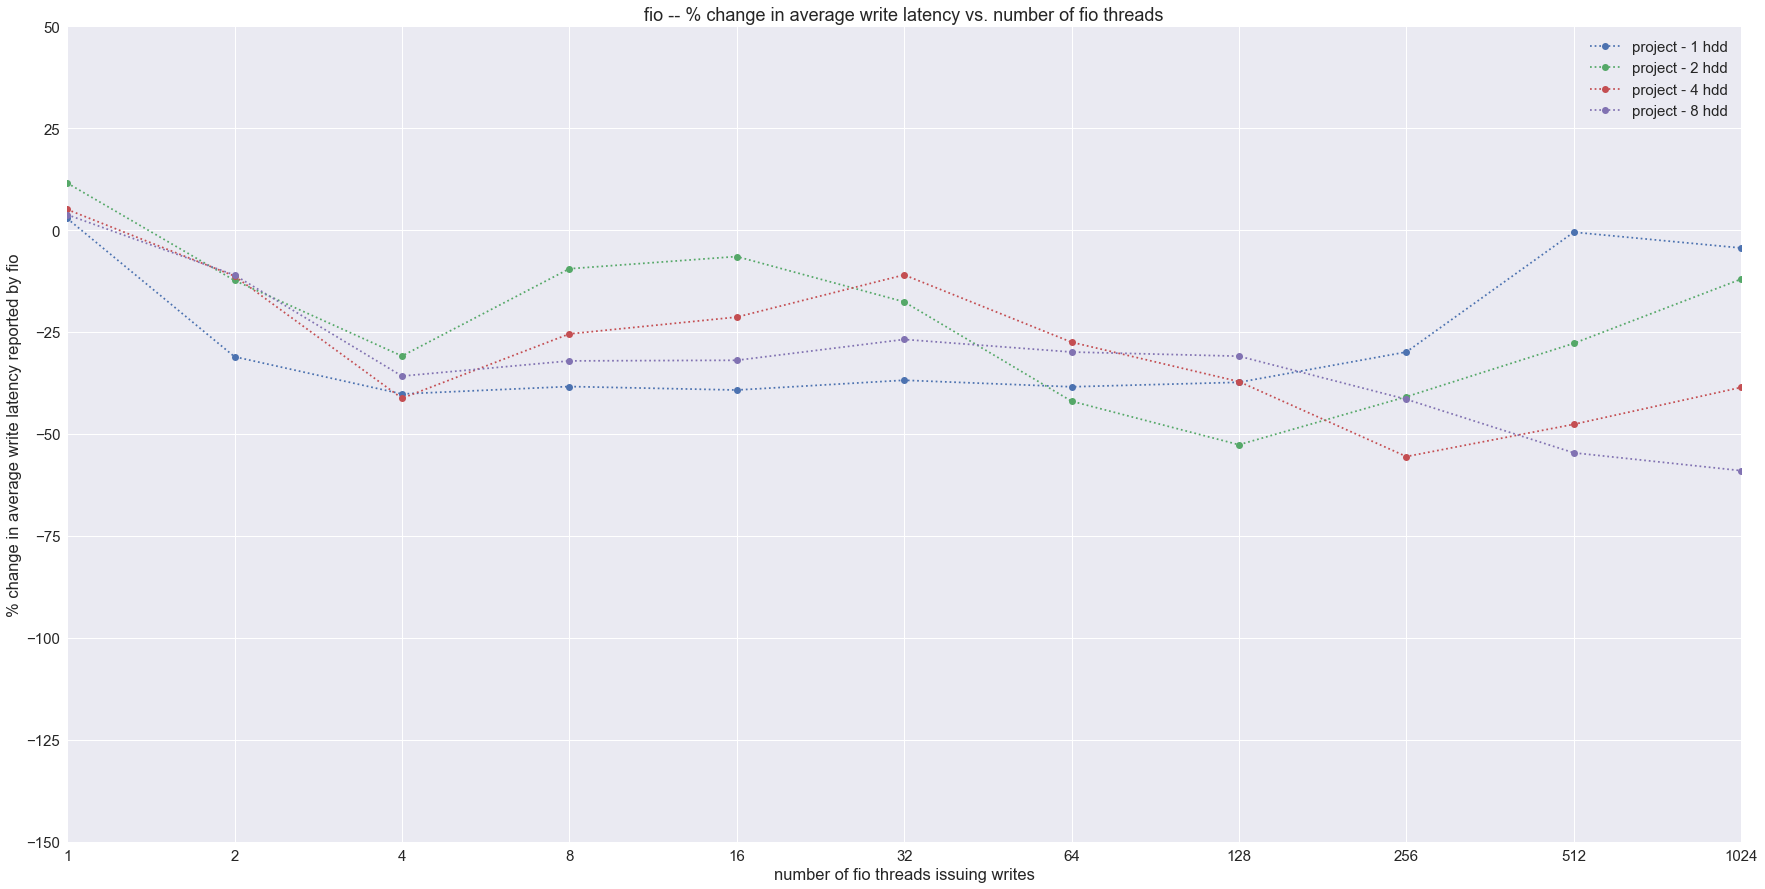

In [13]:
pctchange_latency.plot(figsize=(30, 15), style=':o')
plt.title('fio -- % change in average write latency vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in average write latency reported by fio')
plt.ylim(-150, 50)
plt.xscale('log')
plt.xticks(pctchange_latency.index, pctchange_latency.index)
plt.show()

In [14]:
pctchange_latency

,project - 1 hdd,project - 2 hdd,project - 4 hdd,project - 8 hdd
1,2.885352,11.570347,5.081080,3.801683
2,-31.046444,-12.328761,-11.258759,-11.008324
4,-40.168489,-30.867108,-41.238052,-35.784430
8,-38.351160,-9.456710,-25.441251,-32.064156
16,-39.205229,-6.465447,-21.317697,-31.914562
32,-36.807753,-17.573435,-10.965748,-26.803356
64,-38.415786,-41.946063,-27.475340,-29.883596
128,-37.313717,-52.628649,-37.139445,-30.910123
256,-29.882797,-40.861624,-55.522629,-41.480503
512,-0.494922,-27.764545,-47.616466,-54.609996


## `%b` averaged across all disks in zpool vs. `fio` threads

Below is a graph of the `%b` column from `iostat` for all disks in the zpool.

The values that're shown were generating by using 1 second samples (i.e. `iostat -xn 1`) for each disk in the zpool, for the entire runtime of the test. These samples were then averaged to acheive a single `%b` average for each disk in the zpool. Then, the single value per disk was averaged across all disks in the zpool, to achieve a single `%b` value, representing all disks in the zpool.

This provides an approximation for how utilized the disks in the zpool were, during the runtime of the `fio` workload.

### `%b` averaged across all disks in zpool vs. `fio` threads - master branch

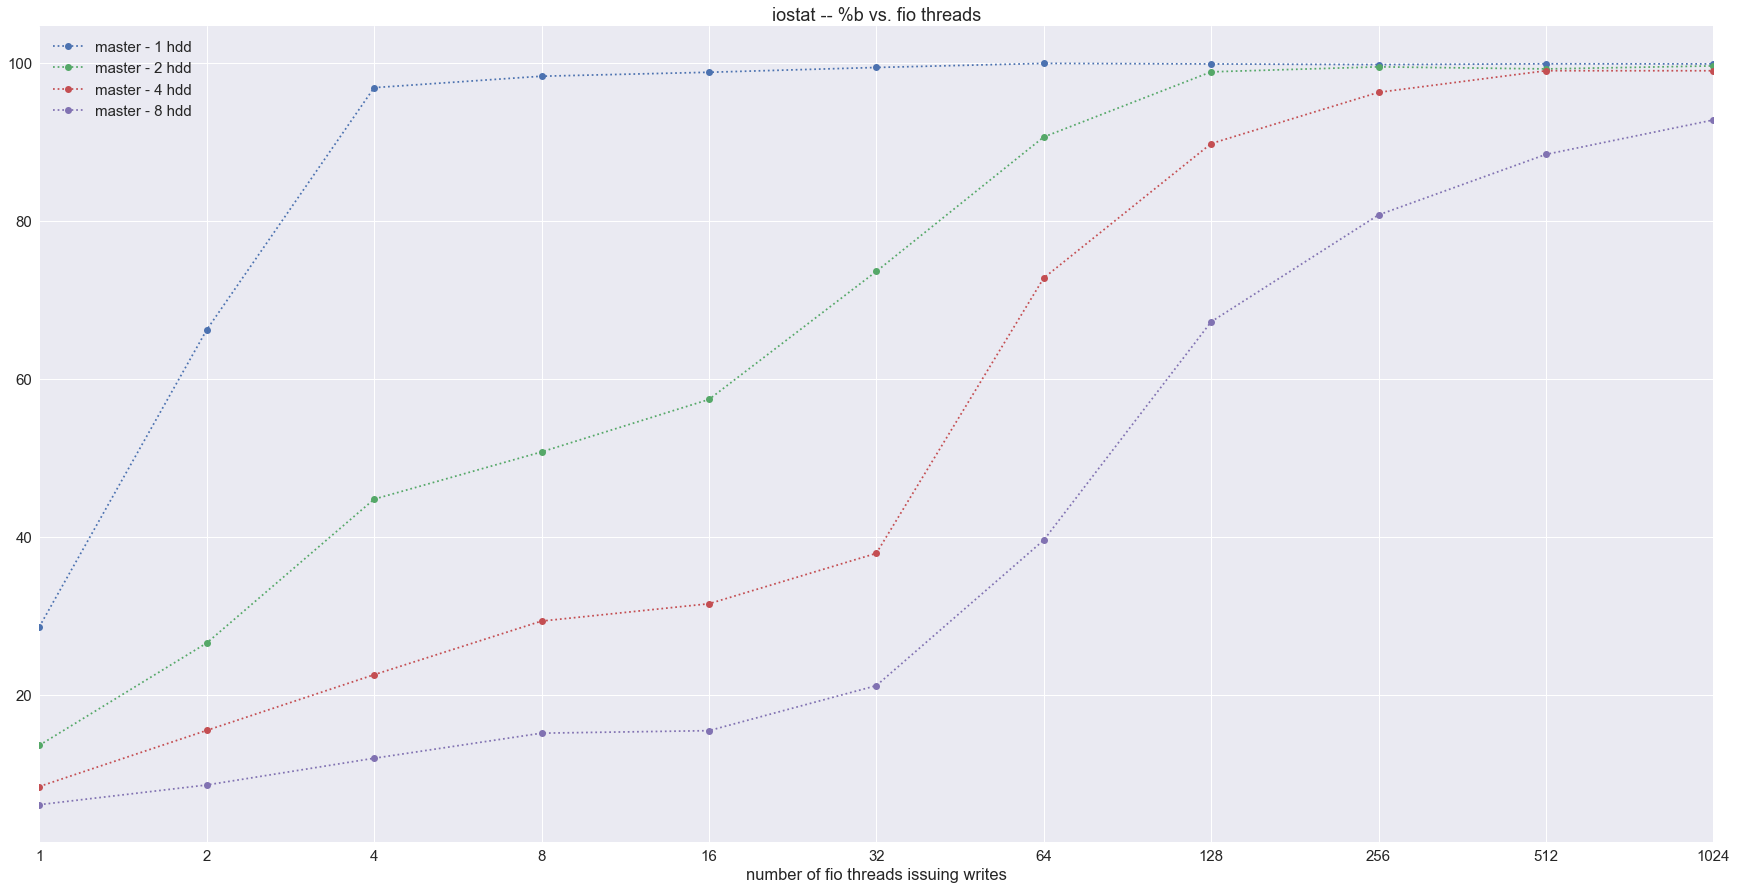

In [15]:
plot_iostat_column_dataframe(master_busy, '%b')

In [16]:
master_busy

,master - 1 hdd,master - 2 hdd,master - 4 hdd,master - 8 hdd
1,28.625000,13.625000,8.403509,6.105263
2,66.232143,26.571429,15.508772,8.596491
4,96.892857,44.785714,22.561404,11.982456
8,98.339286,50.767857,29.350877,15.157895
16,98.839286,57.410714,31.543860,15.473684
32,99.446429,73.625000,37.929825,21.175439
64,99.964286,90.642857,72.789474,39.596491
128,99.892857,98.892857,89.807018,67.245614
256,99.807018,99.526316,96.298246,80.775862
512,99.912281,99.263158,99.034483,88.440678


### `%b` averaged across all disks in zpool vs. `fio` threads - project branch

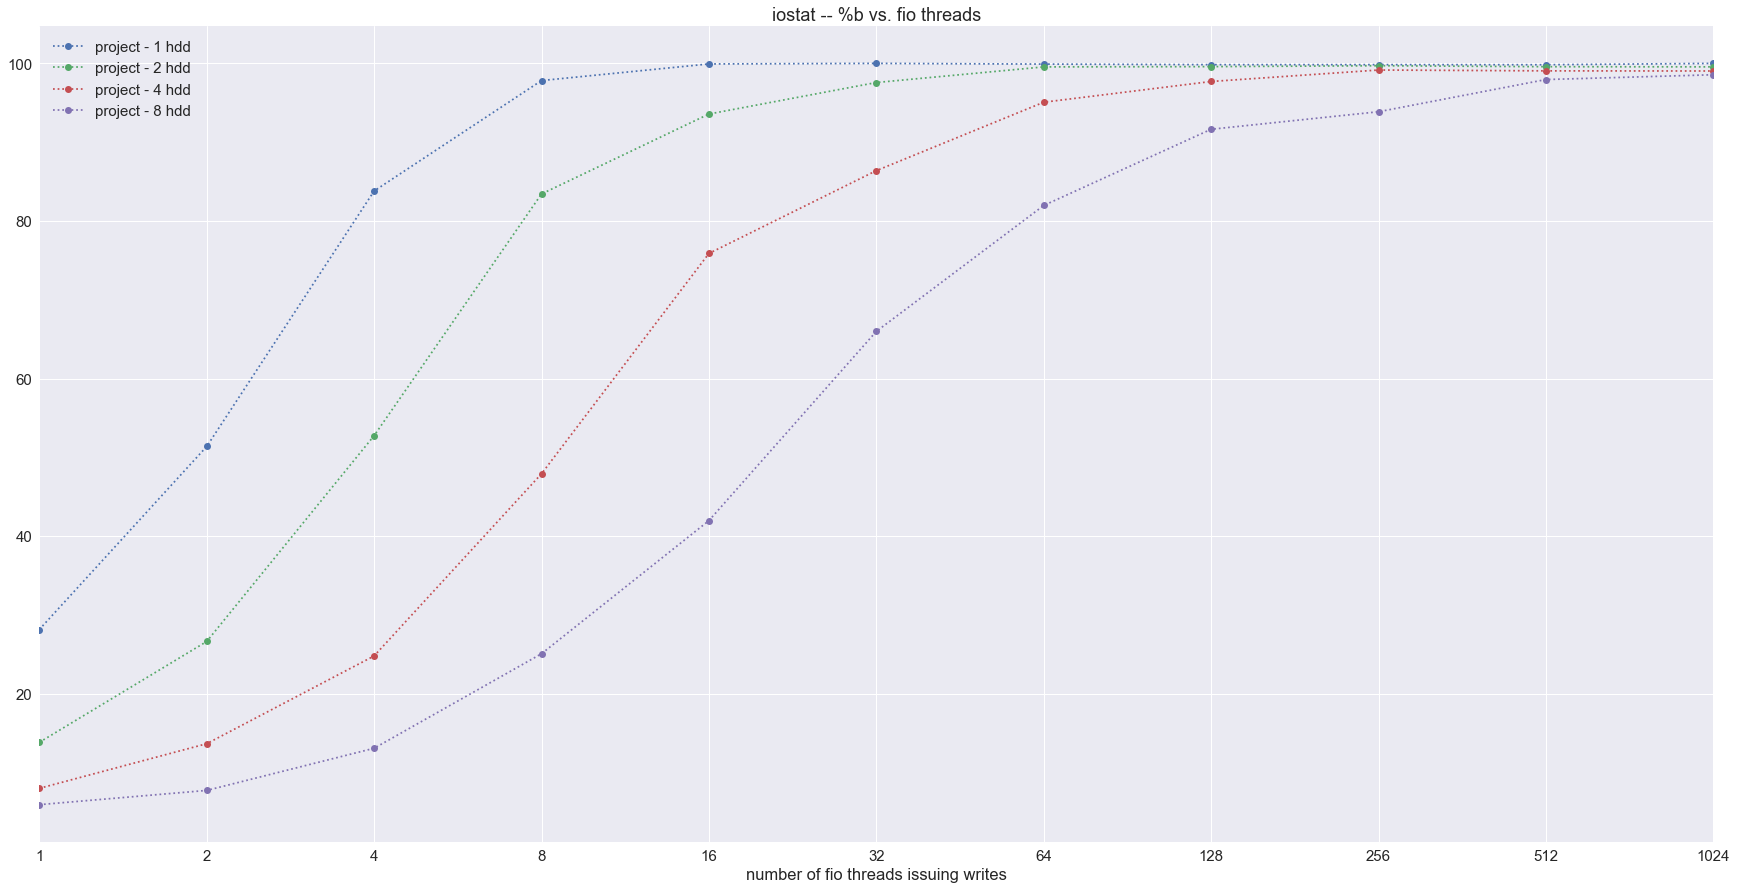

In [17]:
plot_iostat_column_dataframe(project_busy, '%b')

In [18]:
project_busy

,project - 1 hdd,project - 2 hdd,project - 4 hdd,project - 8 hdd
1,28.142857,13.821429,7.982456,5.912281
2,51.375000,26.625000,13.649123,7.719298
4,83.803571,52.750000,24.789474,13.070175
8,97.821429,83.428571,47.912281,25.070175
16,99.928571,93.571429,75.877193,41.964912
32,100.000000,97.571429,86.385965,65.982456
64,99.910714,99.553571,95.070175,81.964912
128,99.839286,99.589286,97.701754,91.637931
256,99.842105,99.701754,99.157895,93.862069
512,99.830508,99.578947,99.051724,97.949153


## on-cpu, system wide, kernel flame graphs

The visualizations below are on-cpu flame-graphs of the entire system, using kernel level stacks. Unlike the line graphs above, there isn't a straightforward way to condense all of the test runs into a single flame-graph visualization. Thus, instead of showing the unique graph for each configuration, 2 configurations were specifically chosen with hopes that these two show a representative sample of the whole population. The two chosen configurations are:

 - 1 disk zpool, with 1024 `fio` threads
 - 8 disk zpool, with 1024 `fio` threads

Both configurations have the largest number of `fio` threads available; and then one configuration has the largest number of disks, and the other configuration has the least number of disks.

### on-cpu, system wide, kernel flame graph - 1 disk - 1024 `fio` threads - master branch

![image](fixed-rate-submit-master-1-hdd-fio-1024-jobs-dtrace-profile.svg)

### on-cpu, system wide, kernel flame graph - 1 disk - 1024 `fio` threads - project branch

![image](fixed-rate-submit-project-1-hdd-fio-1024-jobs-dtrace-profile.svg)

### on-cpu, system wide, kernel flame graph - 8 disks - 1024 `fio` threads - master branch

![image](fixed-rate-submit-master-8-hdd-fio-1024-jobs-dtrace-profile.svg)

### on-cpu, system wide, kernel flame graph - 8 disks - 1024 `fio` threads - project branch

![image](fixed-rate-submit-project-8-hdd-fio-1024-jobs-dtrace-profile.svg)